In [1]:
## imports ###

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import sys
sys.path.append('../')
from models.lvae import LadderVAE
from lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from boilerplate import boilerplate
import lib.utils as utils
from lib import histNoiseModel
from lib.utils import plotProbabilityDistribution
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from pathlib import Path
from skimage.transform import warp,AffineTransform

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cuda


In [2]:
#### ALL PARAMETERS DEFINED HERE ####

# Data paths
basedir = Path(r"E:\dl_monalisa\Data\Vim_fixed_mltplSNR_30nm\_forAnirban")
data_path_signal = basedir / "training_data" / "avg_and_n2v"
data_path_obs = basedir /  "training_data" / "mltpl_snr_stacks"

# Noise Model
noiseModelsDir = basedir / "noiseModel"
GMMname = "GMM_Noise1_SigN2V_Clip-3.npz"
noise_model_params = np.load(str(noiseModelsDir / GMMname))
noiseModel = GaussianMixtureNoiseModel(params = noise_model_params, device = device)

# Data-related parameters
upsamp = 2 # upsampling factor (integer)
upsamp_beforeNN = False # put True to re-upsample with nearest neighbor before feeding in neural net
target = "clean" # "noisy" or "clean"
augment = False
DataNoiseLvl = 1 # "all",list of int, or int 
normSignalToObs = True # put True if signal was normalized to observations when creating GMM
normGMM = True # put True if data was normalized to create the GMM
clip = -3 # False or clip value
display = True

# Model-specific
num_latents = 5
z_dim = 64
z_dims = [z_dim]*int(num_latents)
blocks_per_layer = 6
batchnorm = True
free_bits = 0
n_filters = 128
upsamp_order = "before" # "before" = convtranspose + conv layers before entering HDN, "after" = upsampling during last topdown layer

# Training prm
patch_size = 64
gaussian_noise_std = None
beta = 0.0001 # loss = recon_loss + beta * kl_loss
batch_size=64
virtual_batch = 8
lr=1e-5
max_epochs = 500
steps_per_epoch=400
test_batch_size=10

# Model name for saving
model_name_base = "Vim_mtlplSNR_Noise1_GMM1N2V_ConvTransposeBefore"
modelName = f"{model_name_base}_Upsamp{upsamp}_Clip{clip}_Lat{z_dim}x{num_latents}_{blocks_per_layer}Blocks_betaKL{beta}"
if not augment:
    modelName = modelName + "_NoAugment"

save_model_basedir = "./Trained_model/" 

print(f"Upsamp factor: {upsamp}")
print(f"Target: {target}")
print(f"Noise level: {DataNoiseLvl}")
print(f"GMM: {GMMname}")

print(f"Trained model will be saved at: {save_model_basedir}")
print(f"Model save name: {modelName}")


Upsamp factor: 2
Target: clean
Noise level: 1
GMM: GMM_Noise1_SigN2V_Clip-3.npz
Trained model will be saved at: ./Trained_model/
Model save name: Vim_mtlplSNR_Noise1_GMM1N2V_ConvTransposeBefore_Upsamp2_Clip-3_Lat64x5_6Blocks_betaKL0.0001_NoAugment


In [3]:
##### Load data ####
signal = []
observation = []
filters = ['tif','tiff']

files_signal = os.listdir(data_path_signal)
files_obs = os.listdir(data_path_obs)

for f in files_signal:
    if f.split('.')[-1] not in filters:
        print(f"removing {f} in signals because not in filters")
        files_signal.remove(f)

for f in files_obs:
    if f.split('.')[-1] not in filters:
        print(f"Removing {f} in observations because not in filters")
        files_obs.remove(f)

assert len(files_obs) == len(files_signal)
print(f"\nFound {len(files_signal)} files.\n")

if isinstance(DataNoiseLvl,list) or DataNoiseLvl == "all":
    mltplNoise = True
else:
    mltplNoise = False

for i in range (len(files_obs)):
    file_signal = files_signal [i]
    file_obs = files_obs [i]
    
    # load clean
    im_signal = imread(data_path_signal / file_signal)[0]
    
    # load noisy
    if DataNoiseLvl == "all":
        im_obs  = imread(data_path_obs / file_obs)[:5]
    elif isinstance(DataNoiseLvl,int) or isinstance(DataNoiseLvl,list):
        im_obs = imread(data_path_obs / file_obs)[DataNoiseLvl]

    # clip neg values
    if not isinstance(clip,bool):
        im_obs[im_obs<clip] = 0
        im_signal[im_signal<clip] = 0

    observation.append(im_obs)
    signal.append(im_signal)

    print(f"Signal {file_signal}:\tObservation {file_obs}:\t Shape: {im_obs.shape}")

signal = np.stack(signal)
observation = np.stack(observation)

if mltplNoise:
    nNoise = observation.shape[1]
    nrepeat = observation.shape[1]
    observation = np.reshape(observation,(observation.shape[0]*observation.shape[1],observation.shape[2],observation.shape[3]))    
    signal = np.repeat(signal,nrepeat,axis=0)

# square crop
if signal.shape[-1] != signal.shape[-2]:
    print("Cropping to square")
    a = min(signal.shape[-1],signal.shape[-2])
    signal = signal [...,0:a,0:a]
    observation = observation [...,0:a,0:a]

# opt. normalization signal to target 
if normSignalToObs:
    if mltplNoise:
        signal = (signal - np.mean(signal))/np.std(signal)
        for noise in range(nNoise):
            signal[noise::nNoise] = signal[noise::nNoise] * np.std(observation[noise::nNoise]) + np.mean(observation[noise::nNoise])
    else:
        signal = (signal - np.mean(signal))/np.std(signal)
        signal = signal * np.std(observation) + np.mean(observation)


print("Before normalization:")
print(f"Mean signal {np.mean(signal)}, std signal {np.std(signal)} ")
print(f"Mean observation {np.mean(observation)}, std observation {np.std(observation)} ")

# opt. normalization of data
if normGMM:
    signal = (signal - np.mean(observation)) / np.std(observation)
    observation = (observation - np.mean(observation)) / np.std(observation)

    print("After normalization:")
    print(f"Mean signal {np.mean(signal)}, std signal {np.std(signal)} ")
    print(f"Mean observation {np.mean(observation)}, std observation {np.std(observation)} ")

print(f"\n\nConcatenated arrays:\tSignal: {signal.shape}\tObservation: {observation.shape}")



Found 23 files.

Signal img_and_denoised_02.tiff:	Observation rec_c03_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_03.tiff:	Observation rec_c04_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_04.tiff:	Observation rec_c05_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_05.tiff:	Observation rec_c07_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_06.tiff:	Observation rec_c08_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_07.tiff:	Observation rec_c09_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_08.tiff:	Observation rec_c10_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_09.tiff:	Observation rec_c11_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_10.tiff:	Observation rec_c12_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_11.tiff:	Observation rec_c13_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and_denoised_12.tiff:	Observation rec_c14_rec_CAM.tiff:	 Shape: (1416, 1392)
Signal img_and

Text(0.5, 1.0, 'Clean')

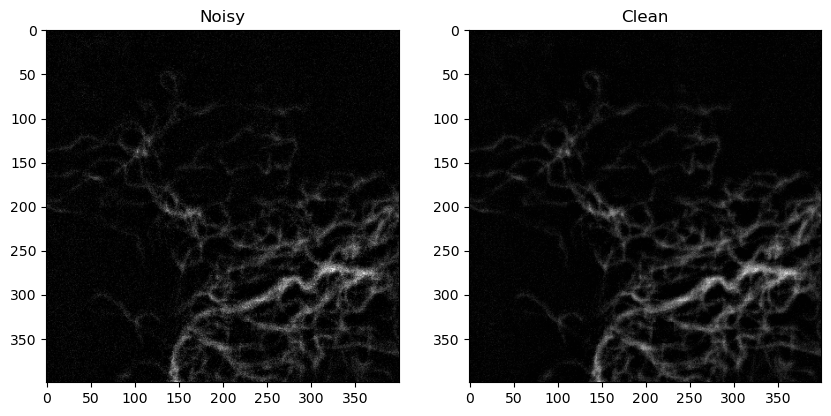

In [4]:
# display examples
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(observation[0][100:500,800:1200],cmap='gray')
plt.title("Noisy")

plt.subplot(1,2,2)
plt.imshow(signal[0][100:500,800:1200],cmap='gray')
plt.title("Clean")

Shape of training images: (19, 1392, 1392) Shape of validation images: (4, 1392, 1392)
Shape of GT training images: (19, 1392, 1392) Shape of validation images: (4, 1392, 1392)


100%|██████████| 4/4 [00:00<00:00, 51.21it/s]


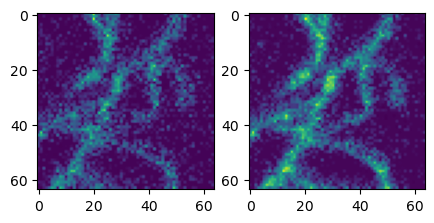

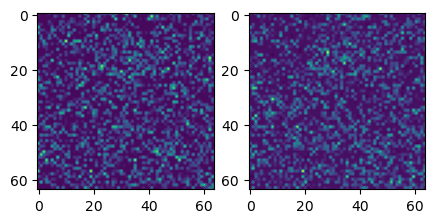

In [5]:
### Train/val split and patch extraction ###

train_data = observation[:int(0.85*observation.shape[0])]
val_data= observation[int(0.85*observation.shape[0]):]
print("Shape of training images:", train_data.shape, "Shape of validation images:", val_data.shape)
if augment:
    train_data = utils.augment_data(train_data) ### Data augmentation disabled for fast training, but can be enabled


if target == "clean":
    train_data_gt = signal[:int(0.85*observation.shape[0])]
    val_data_gt = signal[int(0.85*observation.shape[0]):]
    print("Shape of GT training images:", train_data.shape, "Shape of validation images:", val_data.shape)
    if augment:
        train_data_gt = utils.augment_data(train_data_gt) ### Data augmentation disabled for fast training, but can be enabled


# Patches extraction
img_width = observation.shape[2]
img_height = observation.shape[1]
num_patches = int(float(img_width*img_height)/float(patch_size**2)*1)

if target == "noisy":
    train_images = utils.extract_patches(train_data, patch_size, num_patches)
    val_images = utils.extract_patches(val_data, patch_size, num_patches)

elif target == "clean":
    train_images,train_images_gt = utils.extract_patches_supervised(train_data,train_data_gt, patch_size, num_patches)
    val_images,val_images_gt  = utils.extract_patches_supervised(val_data,val_data_gt, patch_size, num_patches)

# We limit validation patches to 1000 to speed up training but it is not necessary
val_images = val_images[:1000]
if target == "clean":
    val_images_gt = val_images_gt [:1000] 


img_shape = (train_images.shape[1], train_images.shape[2])

# Display of paired dataset to check that it is matching 
if target == "clean":
    import random
    idx = random.randrange(train_images.shape[0])

    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    plt.imshow(train_images[idx])

    plt.subplot(1,2,2)
    plt.imshow(train_images_gt[idx])

    idx = random.randrange(val_images.shape[0])
    plt.figure(figsize=(5,10))
    plt.subplot(1,2,1)
    plt.imshow(val_images[idx])

    plt.subplot(1,2,2)
    plt.imshow(val_images_gt[idx])

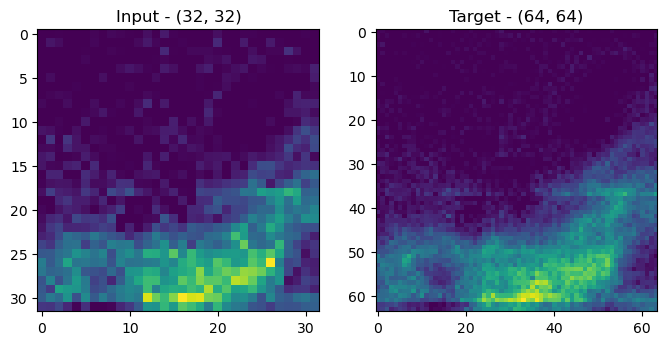

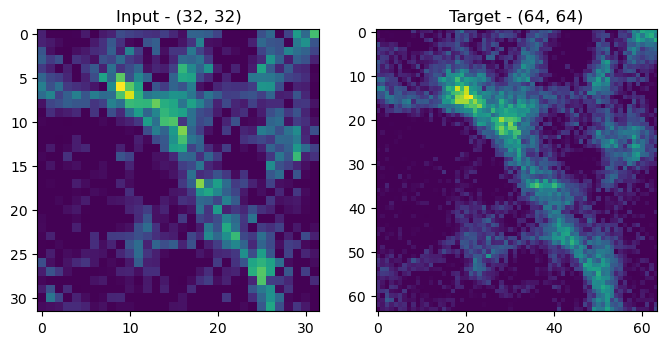

In [6]:
### Dataloaders ###

if target == "noisy":
    train_images_gt = train_images.copy()
    val_images_gt = val_images.copy()

train_loader, val_loader, data_mean, data_std = boilerplate._make_datamanager_supervised(train_images,train_images_gt,val_images,
                                                                                            val_images_gt,batch_size,test_batch_size,
                                                                                            upsamp=upsamp,upsamp_beforeNN = upsamp_beforeNN)


# To make sure that steps_per_epoch not bigger than len(train_loader)
steps_per_epoch=min(len(train_loader)-1,steps_per_epoch)
# print(steps_per_epoch)

# Display 1 patch example for each train and val loader
batch_idx, (x, y) = next(enumerate(train_loader))

idx=47
x2 = x.cpu().numpy()
x2 = x2[idx]
y2 = y.cpu().numpy()
y2 = y2[idx]

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title(f"Input - {x2.shape}")
plt.imshow(x2)
plt.subplot(1,2,2)
plt.title(f"Target - {y2.shape}")
plt.imshow(y2)

batch_idx, (x, y) = next(enumerate(val_loader))
idx=0
x2 = x.cpu().numpy()
x2 = x2[idx]
y2 = y.cpu().numpy()
y2 = y2[idx]

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.title(f"Input - {x2.shape}")
plt.imshow(x2)
plt.subplot(1,2,2)
plt.title(f"Target - {y2.shape}")
plt.imshow(y2)

In [7]:
### Train ###

if upsamp>1:
    initial_upsamp = True if upsamp_order == "before" else False
    final_upsamp = True if upsamp_order == "after" else False
else: 
    initial_upsamp,final_upsamp = False, False

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape,initial_upsamp=initial_upsamp,
                  final_upsamp=final_upsamp).cuda()

model.train() # Model set in training mode

training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=save_model_basedir,
                       train_loader=train_loader,val_loader=val_loader,virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=modelName,val_loss_patience=100,beta=beta)

Epoch[1/500] Training Loss: 1.191 Reconstruction Loss: 1.191 KL Loss: 4.909
saving ./Trained_model/model/Vim_mtlplSNR_Noise1_GMM1N2V_ConvTransposeBefore_Upsamp2_Clip-3_Lat64x5_6Blocks_betaKL0.0001_NoAugment_last_vae.net
saving ./Trained_model/model/Vim_mtlplSNR_Noise1_GMM1N2V_ConvTransposeBefore_Upsamp2_Clip-3_Lat64x5_6Blocks_betaKL0.0001_NoAugment_best_vae.net
Patience: 0 Validation Loss: 4.617276668548584 Min validation loss: 4.617276668548584
Time for epoch: 609seconds
Est remaining time: 3 days, 12:24:51 or 303891 seconds
----------------------------------------
Epoch[2/500] Training Loss: 1.132 Reconstruction Loss: 1.132 KL Loss: 5.512
saving ./Trained_model/model/Vim_mtlplSNR_Noise1_GMM1N2V_ConvTransposeBefore_Upsamp2_Clip-3_Lat64x5_6Blocks_betaKL0.0001_NoAugment_last_vae.net
Patience: 1 Validation Loss: 4.827364921569824 Min validation loss: 4.617276668548584
Time for epoch: 494seconds
Est remaining time: 2 days, 20:20:12 or 246012 seconds
---------------------------------------

KeyboardInterrupt: 

# Plotting losses

In [12]:
directory_path = "./Trained_model/" 
trainHist=np.load(directory_path+"model/train_loss.npy")
reconHist=np.load(directory_path+"model/train_reco_loss.npy")
klHist=np.load(directory_path+"model/train_kl_loss.npy")
valHist=np.load(directory_path+"model/val_loss.npy")

In [ ]:
plt.figure(figsize=(18, 3))
plt.subplot(1,3,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("reconstruction loss")
plt.legend()

plt.subplot(1,3,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()
plt.show()